
# **<center><font style="color:rgb(100,109,254)">Human Action Recognition in Videos using Keras (CNN)</font> </center>**

<center>
<img src='action reco'></center>

In [ ]:
# Install the required libraries.
!pip install tensorflow opencv-contrib-python moviepy pydot

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.5/46.2 MB 558.9 kB/s eta 0:01:22
   ---------------------------------------- 0.5/46.2 MB 558.9 kB/s eta 0:01:22
   --------


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

import moviepy
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('./UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'./UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'./UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
DATASET_DIR = "./UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace", "HorseRiding", "PullUps"]

In [ ]:
def frames_extraction(video_path):

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: HorseRiding
Extracting Data of Class: PullUps


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
def create_LRCN_model():

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

c:\Users\Sheikh\anaconda3\envs\ml_project\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,126 (285.65 KB)

 Trainable params: 73,126 (285.65 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
121/121 ━━━━━━━━━━━━━━━━━━━━ 68s 363ms/step - accuracy: 0.2486 - loss: 1.7749 - val_accuracy: 0.2314 - val_loss: 1.7823
Epoch 2/70
121/121 ━━━━━━━━━━━━━━━━━━━━ 42s 345ms/step - accuracy: 0.3268 - loss: 1.6529 - val_accuracy: 0.3140 - val_loss: 1.6553
Epoch 3/70
121/121 ━━━━━━━━━━━━━━━━━━━━ 42s 344ms/step - accuracy: 0.4005 - loss: 1.4928 - val_accuracy: 0.3636 - val_loss: 1.5623
Epoch 4/70
121/121 ━━━━━━━━━━━━━━━━━━━━ 49s 404ms/step - accuracy: 0.4763 - loss: 1.3649 - val_accuracy: 0.3636 - val_loss: 1.4915
Epoch 5/70
121/121 ━━━━━━━━━━━━━━━━━━━━ 74s 335ms/step - accuracy: 0.4918 - loss: 1.3280 - val_accuracy: 0.3636 - val_loss: 1.6656
Epoch 6/70
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 336ms/step - accuracy: 0.5526 - loss: 1.1677 - val_accuracy: 0.3058 - val_loss: 1.7913
Epoch 7/70
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 334ms/step - accuracy: 0.6171 - loss: 1.1036 - val_accuracy: 0.5537 - val_loss: 1.0980
Epoch 8/70
121/121 ━━━━━━━━━━━━━━━━━━━━ 38s 314ms/step - accuracy: 0.6462 - loss: 0

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8858 - loss: 0.3976


In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Selected Video: ./UCF50\HorseRiding\v_HorseRiding_g03_c06.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Activity: HorseRiding


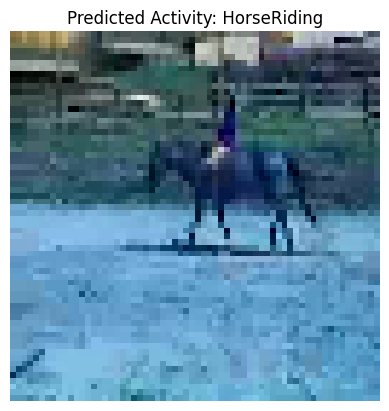

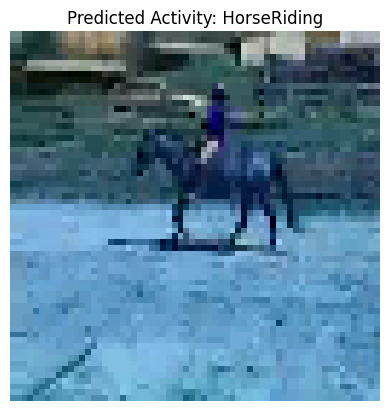

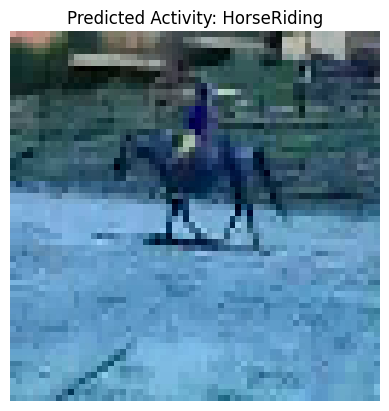

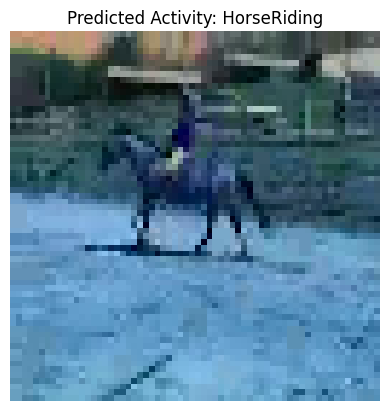

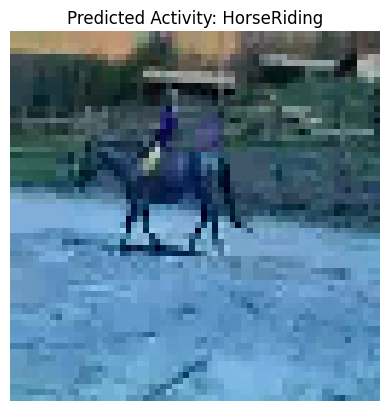

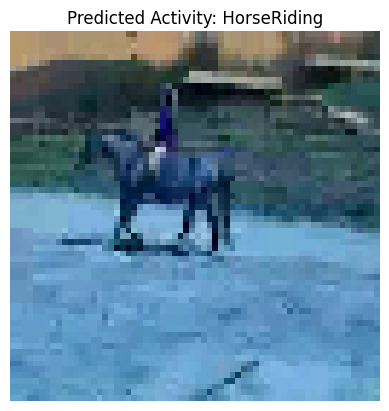

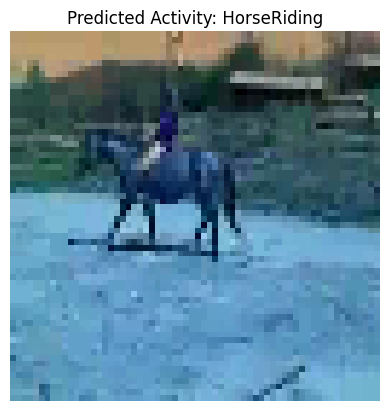

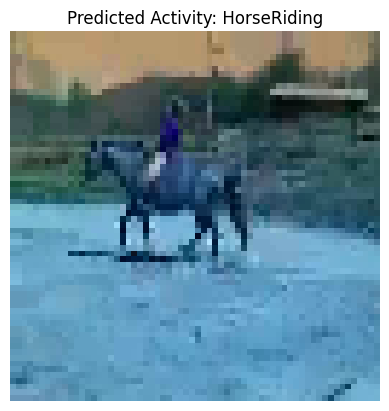

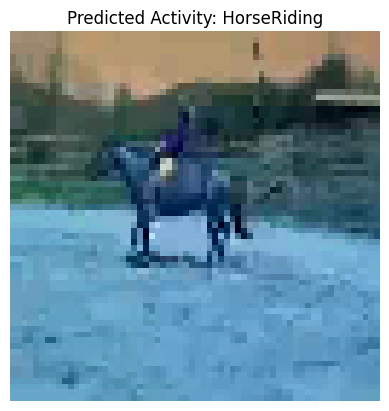

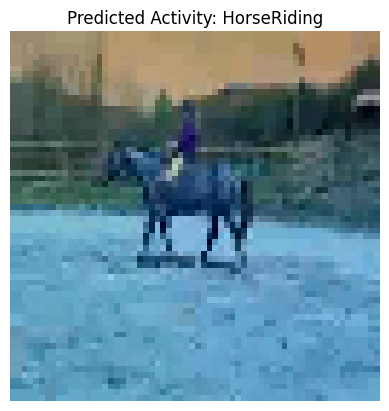

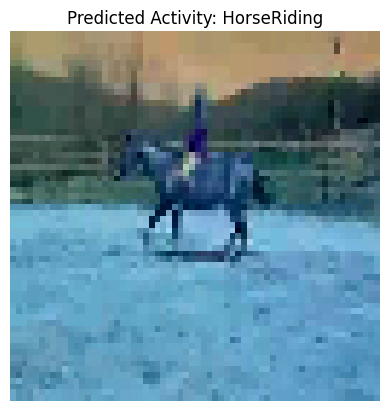

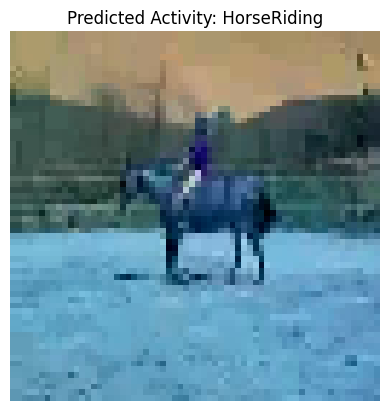

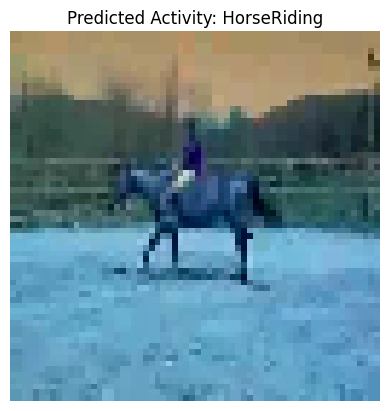

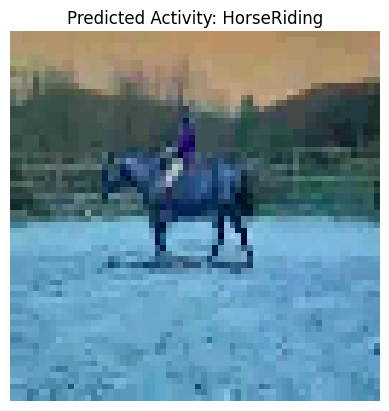

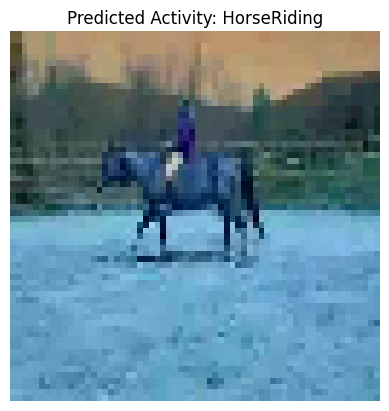

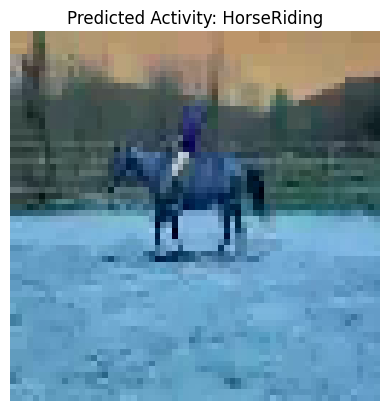

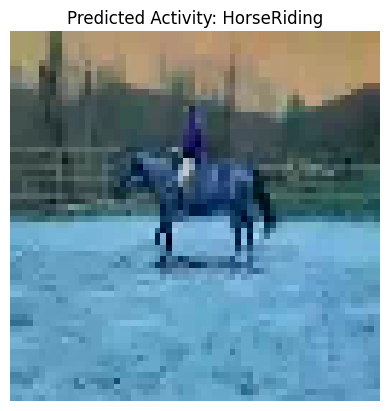

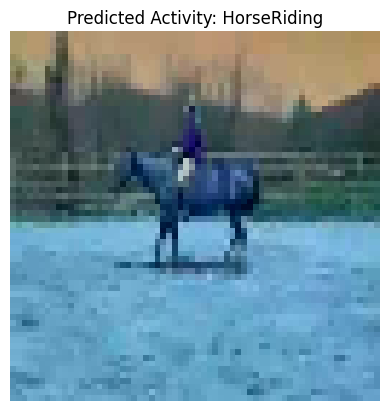

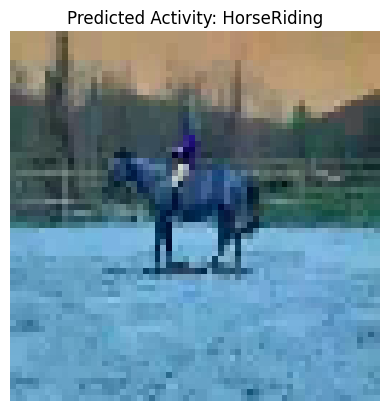

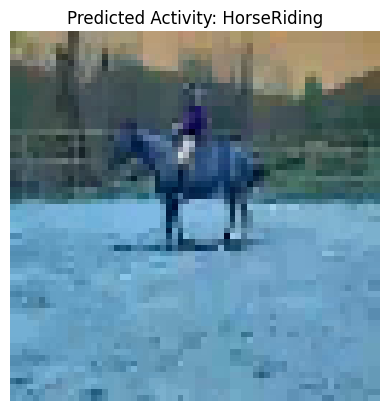

In [ ]:
def recognize_random_video():
    # Choose a random class from the CLASSES_LIST.
    random_class = random.choice(CLASSES_LIST)

    # Get all video files from the selected class directory.
    video_files = os.listdir(os.path.join(DATASET_DIR, random_class))

    # Choose a random video file.
    random_video_file = random.choice(video_files)

    # Get the full path of the random video.
    video_path = os.path.join(DATASET_DIR, random_class, random_video_file)

    # Print the selected video path.
    print(f"Selected Video: {video_path}")

    # Extract frames from the selected video.
    video_frames = frames_extraction(video_path)

    # Ensure the video has the required number of frames for prediction.
    if len(video_frames) == SEQUENCE_LENGTH:
        # Expand dimensions to match the model's input shape.
        video_frames_array = np.expand_dims(video_frames, axis=0)

        # Perform prediction using the trained model.
        predicted_class_probabilities = LRCN_model.predict(video_frames_array)
        predicted_class_index = np.argmax(predicted_class_probabilities)
        predicted_class_name = CLASSES_LIST[predicted_class_index]

        # Display the prediction result.
        print(f"Predicted Activity: {predicted_class_name}")

        # Optionally visualize the video frames.
        for frame in video_frames:
            plt.imshow(frame)
            plt.axis('off')
            plt.title(f"Predicted Activity: {predicted_class_name}")
            plt.show()
    else:
        print("The video does not have enough frames for prediction.")

# Call the function to recognize a random video.
recognize_random_video()


In [ ]:
LRCN_model.save('human_action_recognition_model.h5')


In [ ]:
LRCN_model.save('human_action_recognition_model.keras')


Selected Video: ./random\race.mp4


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted Activity: HorseRace


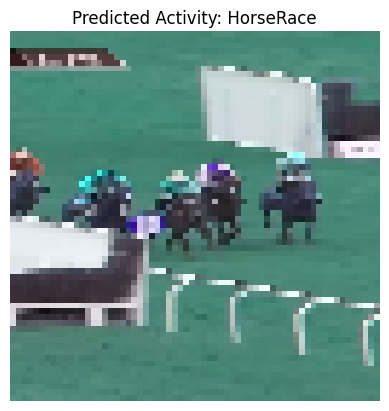

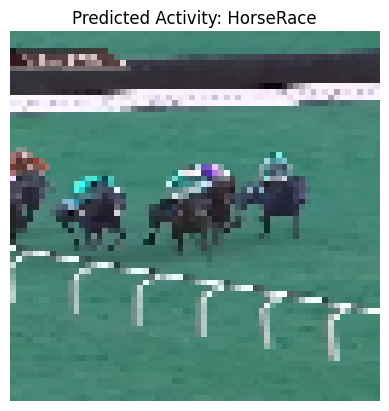

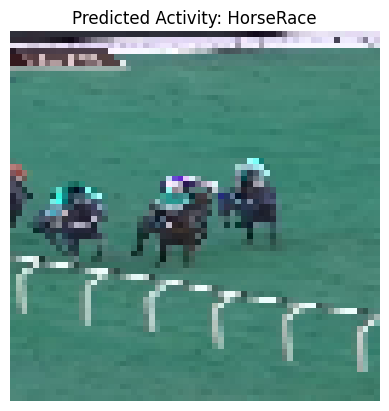

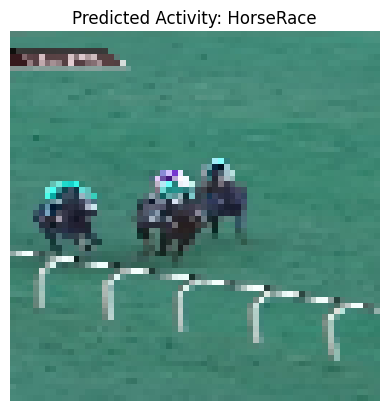

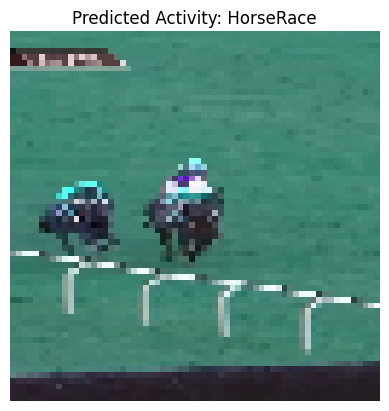

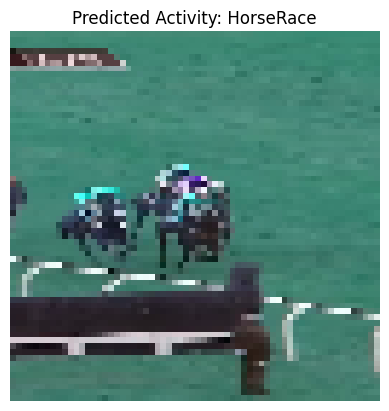

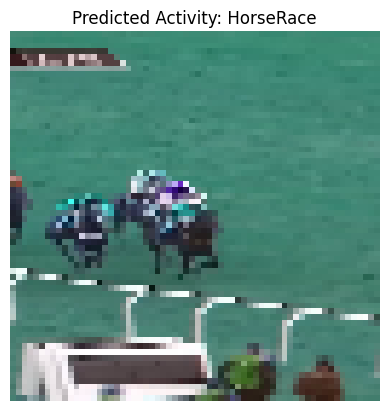

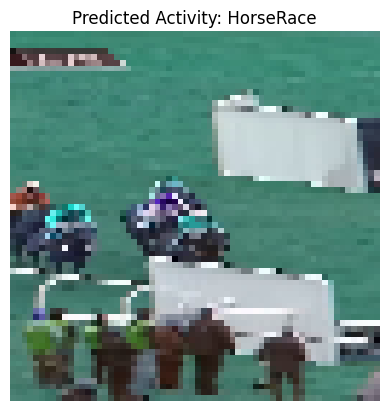

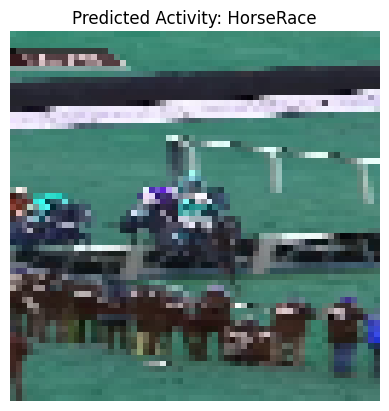

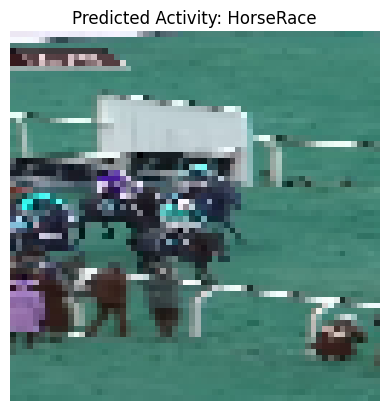

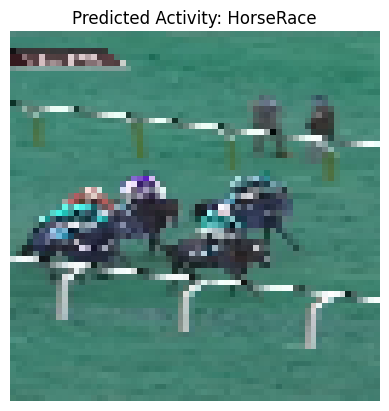

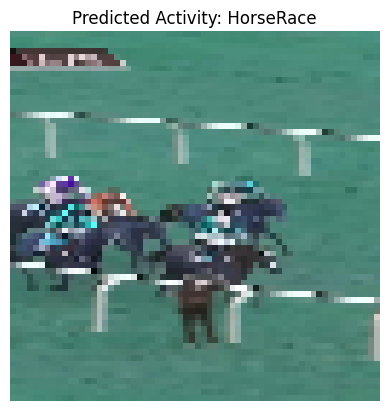

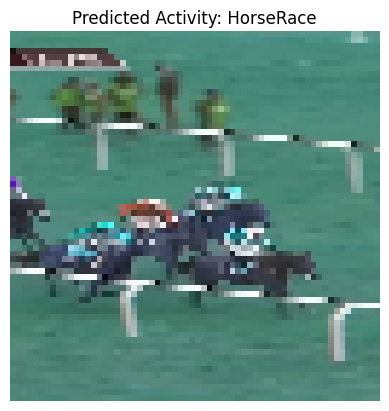

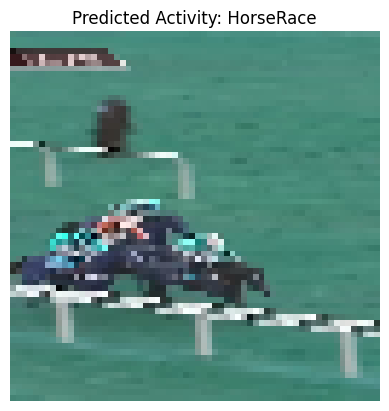

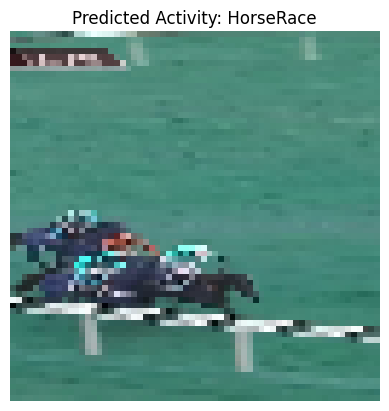

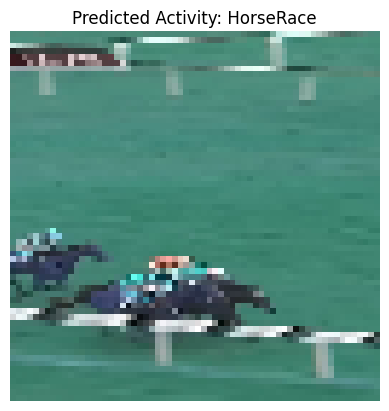

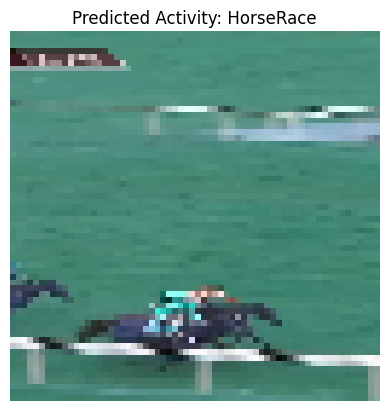

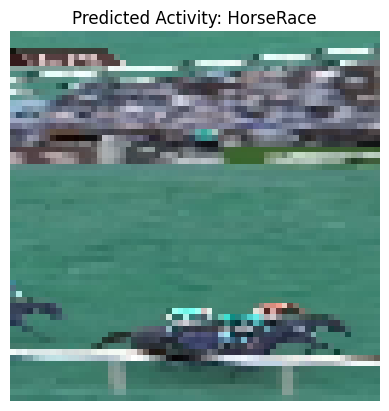

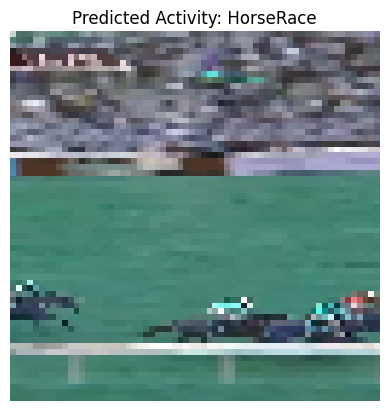

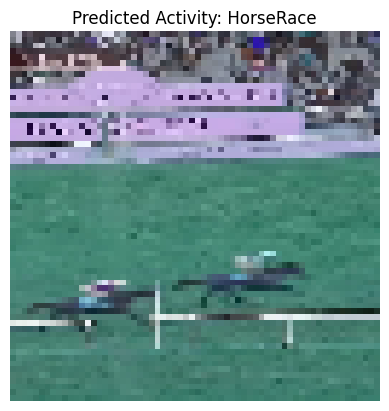

In [ ]:
from tensorflow.keras.models import load_model, model_from_json

# Load entire model
loaded_model = load_model('human_action_recognition_model.h5')

def recognize_random_video_with_model():


    # Get all video files from the selected class directory.
    video_files = os.listdir("./random")

    # Choose a random video file.
    random_video_file = random.choice(video_files)

    # Get the full path of the random video.
    video_path = os.path.join("./random", "race.mp4")

    # Print the selected video path.
    print(f"Selected Video: {video_path}")

    # Extract frames from the selected video.
    video_frames = frames_extraction(video_path)

    # Ensure the video has the required number of frames for prediction.
    if len(video_frames) == SEQUENCE_LENGTH:
        # Expand dimensions to match the model's input shape.
        video_frames_array = np.expand_dims(video_frames, axis=0)

        # Perform prediction using the trained model.
        predicted_class_probabilities = loaded_model.predict(video_frames_array)
        predicted_class_index = np.argmax(predicted_class_probabilities)
        predicted_class_name = CLASSES_LIST[predicted_class_index]

        # Display the prediction result.
        print(f"Predicted Activity: {predicted_class_name}")

        # Optionally visualize the video frames.
        for frame in video_frames:
            plt.imshow(frame)
            plt.axis('off')
            plt.title(f"Predicted Activity: {predicted_class_name}")
            plt.show()
    else:
        print("The video does not have enough frames for prediction.")

# Call the function to recognize a random video.
recognize_random_video_with_model()
